## What I'm aiming to do

- Merge the Store/training data together
- Understand the time structure of the data
- Give about 50% of the times to the training of the model and then leave the rest for real life situations

## TODO

- Models changing vs new data being included. KS test?
- Time series splitter?
    + So I could build three time based train/test splits
    + Need to order the data by date to use this functionality.
- What features can you use?
    + How dodgy time series features can be problematic
- Model UAT? Traffic light

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.externals import joblib

from datetime import datetime

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
store = pd.read_csv('../data/store.csv')
train = pd.read_csv('../data/train.csv')

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
store.head().T

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN
Promo2SinceYear,NaN,2010,2011,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


In [4]:
print(train['Date'].min())
print(train['Date'].max())
train.head().T

2013-01-01
2015-07-31


,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1


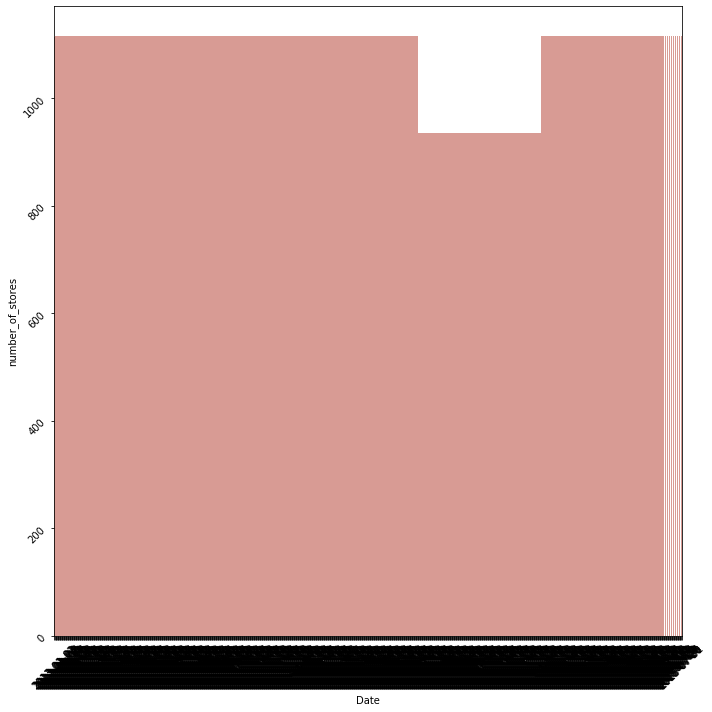

In [5]:
grp_df = train.groupby('Date')['Store'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Store': 'number_of_stores'})

fig, ax = plt.subplots(1, figsize=(10, 10))

sns.barplot(x="Date", y="number_of_stores", data=grp_df,
                  color="salmon", saturation=.5, ax=ax)
ax.tick_params(labelrotation=45)
plt.tight_layout()

## Tidy up the above figure so we can see the x axis labels

So now we can see that there a few stores that we don't have data for a period of time. We'll want to drop those stores

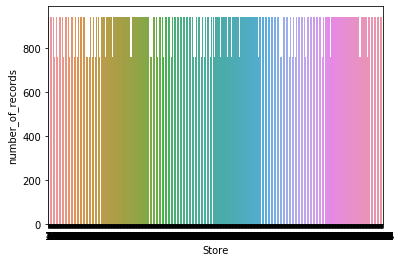

In [6]:
grp_df = train.groupby('Store')['Date'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Date': 'number_of_records'})
sns.barplot(x='Store', y='number_of_records', data=grp_df)

In [7]:
train['store_date_records'] = train.groupby('Store')['Date'].transform('nunique')
print(train['Store'].nunique())
print(train['store_date_records'].value_counts())

train_subset = train.loc[train['store_date_records'] == train['store_date_records'].max(), :]
print(train_subset['Store'].nunique())

1115
942    879828
758    136440
941       941
Name: store_date_records, dtype: int64
934


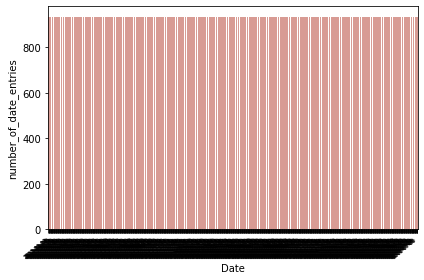

In [8]:
grp_df = train_subset.groupby('Date')['Store'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Store': 'number_of_date_entries'})

ax = sns.barplot(x="Date", y="number_of_date_entries", data=grp_df,
                  color="salmon", saturation=.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=5)
plt.tight_layout()
plt.show()

In [9]:
print(train_subset['Date'].min())
print(train_subset['Date'].max())

2013-01-01
2015-07-31


So every date record that happens before this date will be included in the model build process. Every date after will be incrementaly added to train to replicate real life

In [10]:
train_subset['initial_build_set'] = train_subset['Date'] < '2014-12-31' 

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
train_subset.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
store_date_records,942,942,942,942,942


In [12]:
model_superset = train_subset.merge(store, on='Store')
model_superset.head().T

,0,1,2,3,4
Store,1,1,1,1,1
DayOfWeek,5,4,3,2,1
Date,2015-07-31,2015-07-30,2015-07-29,2015-07-28,2015-07-27
Sales,5263,5020,4782,5011,6102
Customers,555,546,523,560,612
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
store_date_records,942,942,942,942,942


In [13]:
model_set = model_superset.loc[model_superset['initial_build_set'] == True, :]
model_deploy_set = model_superset.loc[model_superset['initial_build_set'] == False, :]

## Setting up train/test

We need to think about data we'll have at prediction time

- Can't include customers as we wouldn't know that ahead of time
- Will need to assume that we know of Promos atleast the max prediction window ahead of time
- I'm just gonna deal with the easy to work with variables

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

from pandas import Series

from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

Want to visualize which days are being put in to train/test

## There might be time overhang with one or two stores being put into the wrong fold but until groupwise time splits are avaiable there ain't much to do

In [14]:
model_set = model_set.sort_values('Date', ascending=True)

modelling_cols = ['DayOfWeek', 
                  'Open', 
                  'Promo', 
                  'StoreType',
                  'Assortment',
                  'CompetitionDistance',
                  'CompetitionOpenSinceMonth'
                 ]

y = model_set['Sales']
X = model_set[modelling_cols]

cats_vars = ['StoreType', 'Assortment']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binary_vars = ['Open', 'Promo']
numeric_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('bins', KBinsDiscretizer(n_bins=5))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cats_vars)],
    remainder='passthrough',
    sparse_threshold=0)
        
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', HistGradientBoostingRegressor())])

tscv = TimeSeriesSplit(n_splits=10)
dates = model_set['Date']

for train_index, test_index in tscv.split(X):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dates_train = dates.iloc[train_index]
    dates_test = dates.iloc[test_index]
    print(F"First date in train = {dates_train.min()}, last date in train = {dates_train.max()}")
    print(F"First date in test = {dates_test.min()}, last date in test = {dates_test.max()}")
    
    train_min  = dates_train.min().replace('-', '_')
    train_max  = dates_train.max().replace('-', '_')
    test_min  = dates_test.min().replace('-', '_')
    test_max  = dates_test.max().replace('-', '_')
    
    clf.fit(X_train, y_train)
        
    train = pd.concat([X_train, y_train, dates_train], axis=1)
    test = pd.concat([X_test, y_test, dates_test], axis=1)
    
    joblib.dump(clf, F'../models/{train_min}_{train_max}_pipe.pkl')
    train.to_csv(F'../models/{train_min}_{train_max}_train.csv', index=False)
    test.to_csv(F'../models/{test_min}_{test_max}_test.csv', index=False)

TRAIN: [    0     1     2 ... 61903 61904 61905] TEST: [ 61906  61907  61908 ... 123801 123802 123803]
First date in train = 2013-01-01, last date in train = 2013-03-08
First date in test = 2013-03-08, last date in test = 2013-05-13


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 123801 123802 123803] TEST: [123804 123805 123806 ... 185699 185700 185701]
First date in train = 2013-01-01, last date in train = 2013-05-13
First date in test = 2013-05-13, last date in test = 2013-07-18


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 185699 185700 185701] TEST: [185702 185703 185704 ... 247597 247598 247599]
First date in train = 2013-01-01, last date in train = 2013-07-18
First date in test = 2013-07-18, last date in test = 2013-09-23


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 247597 247598 247599] TEST: [247600 247601 247602 ... 309495 309496 309497]
First date in train = 2013-01-01, last date in train = 2013-09-23
First date in test = 2013-09-23, last date in test = 2013-11-28


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 309495 309496 309497] TEST: [309498 309499 309500 ... 371393 371394 371395]
First date in train = 2013-01-01, last date in train = 2013-11-28
First date in test = 2013-11-28, last date in test = 2014-02-02


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 371393 371394 371395] TEST: [371396 371397 371398 ... 433291 433292 433293]
First date in train = 2013-01-01, last date in train = 2014-02-02
First date in test = 2014-02-02, last date in test = 2014-04-09


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 433291 433292 433293] TEST: [433294 433295 433296 ... 495189 495190 495191]
First date in train = 2013-01-01, last date in train = 2014-04-09
First date in test = 2014-04-09, last date in test = 2014-06-15


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 495189 495190 495191] TEST: [495192 495193 495194 ... 557087 557088 557089]
First date in train = 2013-01-01, last date in train = 2014-06-15
First date in test = 2014-06-15, last date in test = 2014-08-20


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 557087 557088 557089] TEST: [557090 557091 557092 ... 618985 618986 618987]
First date in train = 2013-01-01, last date in train = 2014-08-20
First date in test = 2014-08-20, last date in test = 2014-10-25


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TRAIN: [     0      1      2 ... 618985 618986 618987] TEST: [618988 618989 618990 ... 680883 680884 680885]
First date in train = 2013-01-01, last date in train = 2014-10-25
First date in test = 2014-10-25, last date in test = 2014-12-30


C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


## Which of these models are the best at predicting on the holdout set?

More data might not make the best models..

In [15]:
from glob import glob

models = glob('../models/*.pkl')
y_holdout = model_deploy_set['Sales']
X_holdout = model_deploy_set[modelling_cols]

results = []

for model in models:
    
    print(model)
    
    pipe = joblib.load(model)
    y_pred = pipe.predict(X_holdout)
    
    r2 = r2_score(y_holdout, y_pred)
    mse = mean_squared_error(y_holdout, y_pred)
    mae = mean_absolute_error(y_holdout, y_pred)
    me = max_error(y_holdout, y_pred)
    
    print(F"R2 score on holdout = {r2}")
    print(F"MSE score on holdout = {mse}")
    print(F"MAE score on holdout = {mae}")
    print(F"Max error on holdout = {me}")
    
    d = {
        'model': model.split('\\')[1],
        'r2_score': r2,
        'mse': mse,
        'mae': mae,
        'max_error': me
    }
                             
    results.append(d)
    
results_df = pd.DataFrame(results)
results_df.to_csv('../data/model_runs.csv', index=False)

../models\2013_01_01_2013_03_08_pipe.pkl
R2 score on holdout = 0.6248437068709443
MSE score on holdout = 5642142.652896032
MAE score on holdout = 1563.9214007192468
Max error on holdout = 25952.83378693211
../models\2013_01_01_2013_05_02_pipe.pkl
R2 score on holdout = 0.6684582566258468
MSE score on holdout = 4986204.005548487
MAE score on holdout = 1482.908117428459
Max error on holdout = 25660.98400267996
../models\2013_01_01_2013_05_13_pipe.pkl
R2 score on holdout = 0.6376173713543496
MSE score on holdout = 5450033.821095598
MAE score on holdout = 1542.6653163543378
Max error on holdout = 25929.359964261675
../models\2013_01_01_2013_07_18_pipe.pkl
R2 score on holdout = 0.6430530883847436
MSE score on holdout = 5368283.650652078
MAE score on holdout = 1531.3702538214836
Max error on holdout = 25705.505781845197
../models\2013_01_01_2013_08_31_pipe.pkl
R2 score on holdout = 0.6787692796998908
MSE score on holdout = 4831131.935196609
MAE score on holdout = 1463.6639805689133
Max error 

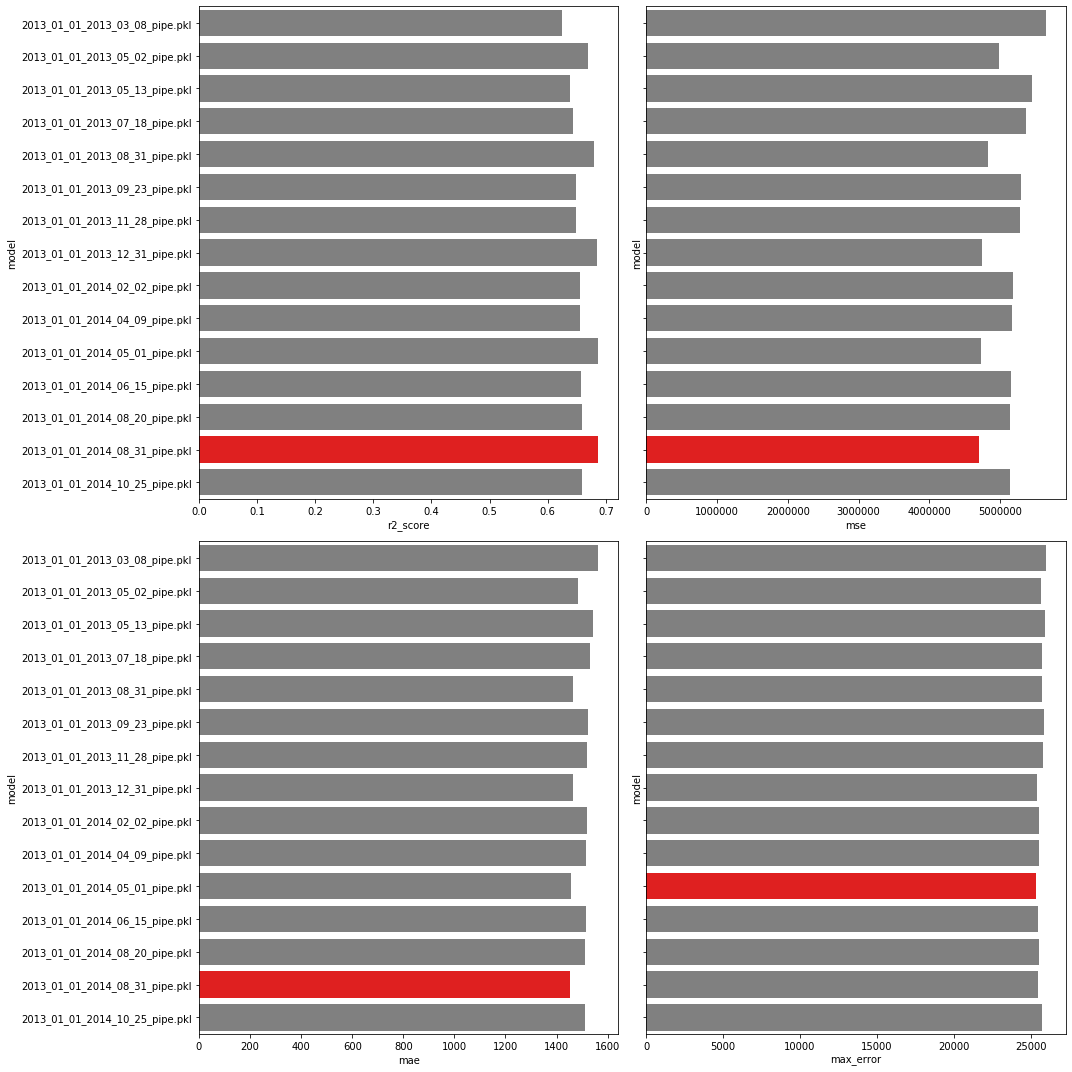

In [16]:
# results_df.sort_values('r2_score', ascending=False)

fig, ax = plt.subplots(2, 2, sharey=True, figsize=(15,15))

values = np.array(results_df['r2_score'])   
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y='model', x='r2_score', data=results_df, palette=clrs, ax=ax[0, 0])

values = np.array(results_df['mse'])   
clrs = ['grey' if (x > min(values)) else 'red' for x in values ]
sns.barplot(y='model', x='mse', data=results_df, palette=clrs, ax=ax[0, 1])

values = np.array(results_df['mae'])   
clrs = ['grey' if (x > min(values)) else 'red' for x in values ]
sns.barplot(y='model', x='mae', data=results_df, palette=clrs, ax=ax[1, 0])

values = np.array(results_df['max_error'])   
clrs = ['grey' if (x > min(values)) else 'red' for x in values ]
sns.barplot(y='model', x='max_error', data=results_df, palette=clrs, ax=ax[1, 1])

plt.tight_layout()
fig.savefig('../graphics/model_period_eval.png', dpi=fig.dpi)

2013-01-01 -> 2014-10-25 seems to be very good. Maybe the last model has the least test data and is getting held back because the test data has changed?

# How about we build a model for train/test but ensure that the train test only has a year worth of data?

So take the last year of the train split and subtract 1 year from it. Maybe give the option to go from 3 months to 12 months